In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf
import tensorflow.keras as keras
import keras.metrics as metrics
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import KFold

import data_visualisation as dv
import data_augmentation as da

import models.cnn as cnn
import models.resnet as resnet


2024-05-22 19:06:45.311324: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 19:06:45.822870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-22 19:06:45.822929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-22 19:06:45.822935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def augment_ecg_signal(signal,):
    drifted_signal, _ = da.add_random_baseline_drift(signal, strength_range=(2 ,3), drift_wavelength_range=(300,500))
    noised_drifted_signal = da.add_random_noise(drifted_signal, (0.1, 0.2))
    return signal

def augment_ecg_signal_batch(signals, labels, batch_size):
    while True:
        
        indices = np.random.randint(0, signals.shape[0], size=batch_size)
        batch = signals[indices]
        batch_labels = labels[indices]
        
        augmented_batch = np.array([augment_ecg_signal(sample) for sample in batch])
        
        yield (augmented_batch, batch_labels)

In [3]:
thismodule = sys.modules[__name__]
# NP_DATA = 'data/DAT_China.npz'
NP_DATA = 'data/DAT_China_1s.npz'

with np.load(NP_DATA, allow_pickle=True) as data:
    for k in data.keys():
        if 'text' in k:
            setattr(thismodule, k, data[k])
        else:
            setattr(thismodule, k, data[k].astype(float))
            
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print(folds_train.shape)

# convert the labels to binary
Y_train = np.where(Y_train == 1, True, False)
Y_test = np.where(Y_test == 1, True, False)

(8386, 100, 12) (8386,)
(2159, 100, 12) (2159,)
(8386,)


In [4]:
label_dict = {
    0: 'Normal',
    1: 'Brugada',
    2: 'RBBB'
}

print("Train label distribution")
t = np.unique(Y_train, return_counts=True)
for i in range(len(t[0])):
    print(label_dict[t[0][i]], ":", t[1][i], "\t", f'{t[1][i] / (np.sum(t[1])) : .2f}%',)
    
print("\nTest label distribution")
t = np.unique(Y_test, return_counts=True)
for i in range(len(t[0])):
    print(label_dict[t[0][i]], ":", t[1][i], "\t", f'{t[1][i] / (np.sum(t[1])) : .2f}%',)

Train label distribution
Normal : 6272 	  0.75%
Brugada : 2114 	  0.25%

Test label distribution
Normal : 1637 	  0.76%
Brugada : 522 	  0.24%


In [5]:
num_classes = 1
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = cnn.model(X_input, num_classes=num_classes, filters=[12, 18, 24], kernels=[5,5,3], hidden_units=[32, 8], dropout=[0.5, 0.5])

model = keras.Model(inputs=X_input, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'Accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 12)]         0         
                                                                 
 conv1d (Conv1D)             (None, 96, 12)            732       
                                                                 
 batch_normalization (BatchN  (None, 96, 12)           48        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 12)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 12)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 18)            1098  

2024-05-22 15:44:25.535736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 15:44:25.590455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 15:44:25.590660: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-22 15:44:25.591222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [33]:
#define rnn model

def rnn_model(X, num_classes=1, units = 32):
        
        # X = keras.layers.Bidirectional(keras.layers.LSTM(units, return_sequences=True))(X)
        X = keras.layers.Bidirectional(keras.layers.LSTM(units, return_sequences=False))(X)
        
        # dropout layer
        # X = keras.layers.Dropout(0.5)(X)
        X = keras.layers.Dense(16, activation='relu')(X)
        X = keras.layers.Dropout(0.2)(X)
        X = keras.layers.Dense(num_classes, activation='sigmoid')(X)
        
        return X
    
X_input = keras.Input(shape=X_train.shape[1:])
outputs = rnn_model(X_input)
model = keras.Model(inputs=X_input, outputs=outputs)
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200, 12)]         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               11520     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,577
Trainable params: 12,577
Non-trainable params: 0
_______________________________________________________

Training on fold 1
Epoch 1/50
230/230 [==============================] - 3s 6ms/step - loss: 0.5639 - accuracy: 0.7372 - precision_18: 0.3421 - recall_18: 0.0493 - auc_18: 0.5969 - val_loss: 0.4855 - val_accuracy: 0.7474 - val_precision_18: 0.5806 - val_recall_18: 0.0667 - val_auc_18: 0.8027
Epoch 2/50
230/230 [==============================] - 1s 5ms/step - loss: 0.4311 - accuracy: 0.7971 - precision_18: 0.7637 - recall_18: 0.2787 - auc_18: 0.8384 - val_loss: 0.4248 - val_accuracy: 0.7912 - val_precision_18: 0.8806 - val_recall_18: 0.2185 - val_auc_18: 0.9348
Epoch 3/50
230/230 [==============================] - 1s 6ms/step - loss: 0.2656 - accuracy: 0.8997 - precision_18: 0.8290 - recall_18: 0.7570 - auc_18: 0.9461 - val_loss: 0.2612 - val_accuracy: 0.8942 - val_precision_18: 0.9251 - val_recall_18: 0.6407 - val_auc_18: 0.9796
Epoch 4/50
230/230 [==============================] - 1s 5ms/step - loss: 0.1796 - accuracy: 0.9368 - precision_18: 0.8758 - recall_18: 0.8720 - auc_18: 0.9722

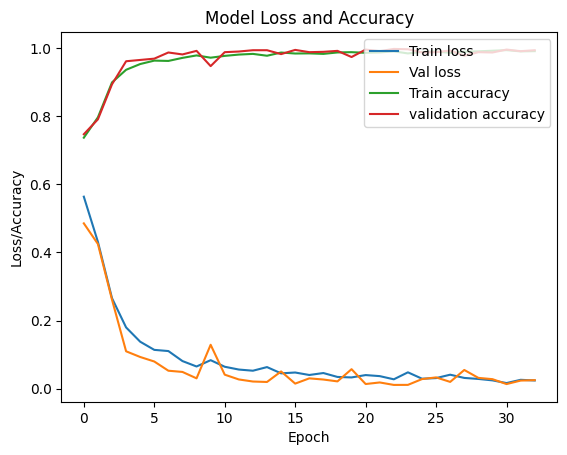

Validation Set:
F1 score for fold 1 0.9962962962962963
Accuracy score for fold 1 0.998093422306959
Test Set:
F1 score for fold 1 0.9100817438692099
Accuracy score for fold 1 0.9541454377026402


Training on fold 2
Epoch 1/50
230/230 [==============================] - 3s 6ms/step - loss: 0.5478 - accuracy: 0.7368 - precision_19: 0.4421 - recall_19: 0.1563 - auc_19: 0.6579 - val_loss: 0.4494 - val_accuracy: 0.7588 - val_precision_19: 0.5682 - val_recall_19: 0.0965 - val_auc_19: 0.8491
Epoch 2/50
230/230 [==============================] - 1s 5ms/step - loss: 0.3782 - accuracy: 0.8370 - precision_19: 0.7685 - recall_19: 0.5084 - auc_19: 0.8808 - val_loss: 0.2884 - val_accuracy: 0.8618 - val_precision_19: 0.8701 - val_recall_19: 0.5174 - val_auc_19: 0.9553
Epoch 3/50
230/230 [==============================] - 1s 5ms/step - loss: 0.2518 - accuracy: 0.9053 - precision_19: 0.8288 - recall_19: 0.7881 - auc_19: 0.9498 - val_loss: 0.2134 - val_accuracy: 0.9180 - val_precision_19: 0.9482 - val_rec

KeyboardInterrupt: 

In [14]:
k = 8
kf = KFold(n_splits=k, shuffle=True, random_state=42)

num_classes = 1
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = cnn.model(X_input, num_classes=num_classes, filters=[12, 18, 24], kernels=[5,5,3], hidden_units=[32, 8], dropout=[0.5, 0.5])

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Training on fold {i+1}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    # create new model
    num_classes = 1
    X_input = keras.Input(shape=X_train.shape[1:])
    outputs, feature_output = cnn.model(X_input, num_classes=num_classes, filters=[12, 18, 24], kernels=[5,5,3], hidden_units=[32, 8], dropout=[0.5, 0.5])
    model = keras.Model(inputs=X_input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
    
    # evaluate the model (sanity check)
    # y_pred = model.predict(X_val_fold, verbose=0)
    # y_pred_binary = np.round(y_pred)
    # y_true = Y_val_fold
    # print("pre train perf:")
    # print(f"F1 score for fold {i+1}", f1_score(y_true, y_pred_binary), f"\t Accuracy score for fold {i+1}", accuracy_score(y_true, y_pred_binary))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # train the model
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])
    print("Training completed after", len(history.epoch), "epochs")
    
    # plot the training and validation loss and binary accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Loss and Accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Val loss', 'Train accuracy', 'validation accuracy'], loc='upper right')
    plt.show()
    
    # validation performance
    Y_pred_fold = model.predict(X_val_fold, verbose=0)
    Y_pred_binary_fold = np.round(Y_pred_fold)
    Y_true_fold = Y_val_fold
    print("Validation Set:")
    print(f"F1 score for fold {i+1}", f1_score(Y_true_fold, Y_pred_binary_fold))
    print(f"Accuracy score for fold {i+1}", accuracy_score(Y_true_fold, Y_pred_binary_fold))
    
    # test performance
    Y_pred_fold = model.predict(X_test, verbose=0)
    Y_pred_binary_fold = np.round(Y_pred_fold)
    Y_true_fold = Y_test
    print("Test Set:")
    print(f"F1 score for fold {i+1}", f1_score(Y_true_fold, Y_pred_binary_fold))
    print(f"Accuracy score for fold {i+1}", accuracy_score(Y_true_fold, Y_pred_binary_fold))
    print("\n")

Training on 8 folds
Training on fold 1
Training completed after 20 epochs


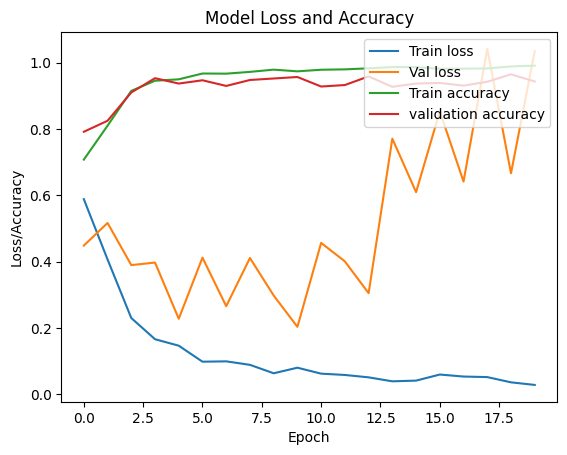

Validation Set:
F1 score for fold 1 0.8873239436619719
Accuracy score for fold 1 0.9569120287253142
Test Set:
F1 score for fold 1 0.8999081726354453
Accuracy score for fold 1 0.9495136637332098


Training on fold 2
Training completed after 15 epochs


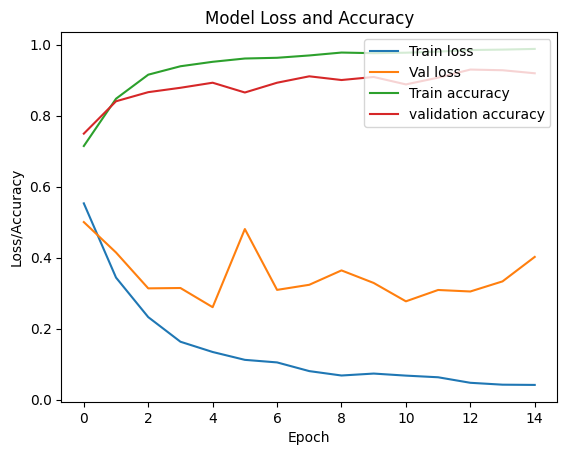

Validation Set:
F1 score for fold 2 0.8014059753954307
Accuracy score for fold 2 0.8926875593542261
Test Set:
F1 score for fold 2 0.8716216216216217
Accuracy score for fold 2 0.9295970356646596


Training on fold 3
Training completed after 20 epochs


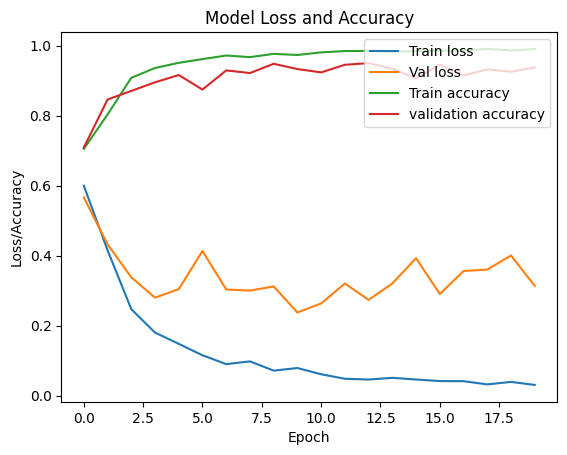

Validation Set:
F1 score for fold 3 0.8818635607321131
Accuracy score for fold 3 0.9328922495274102
Test Set:
F1 score for fold 3 0.9147005444646098
Accuracy score for fold 3 0.9564613246873552


Training on fold 4
Training completed after 18 epochs


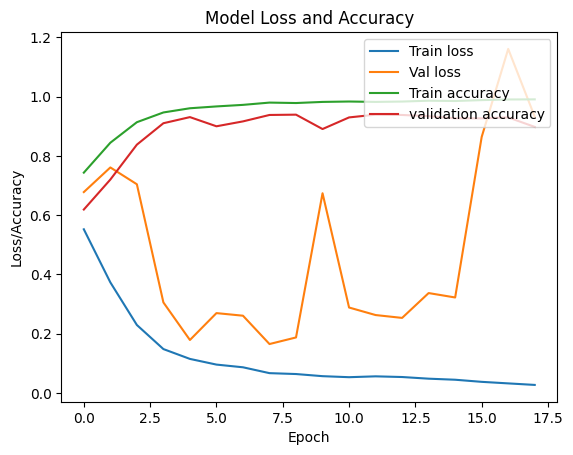

Validation Set:
F1 score for fold 4 0.9127906976744187
Accuracy score for fold 4 0.9380165289256198
Test Set:
F1 score for fold 4 0.8732394366197184
Accuracy score for fold 4 0.9333024548402038


Training on fold 5
Training completed after 29 epochs


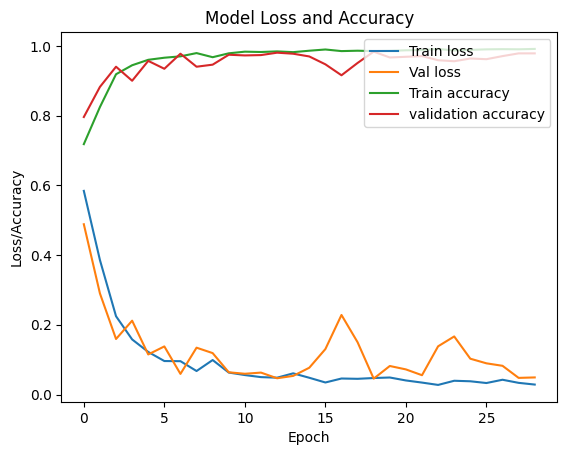

Validation Set:
F1 score for fold 5 0.9598108747044917
Accuracy score for fold 5 0.9833169774288518
Test Set:
F1 score for fold 5 0.9035812672176309
Accuracy score for fold 5 0.951366373320982


Training on fold 6
Training completed after 17 epochs


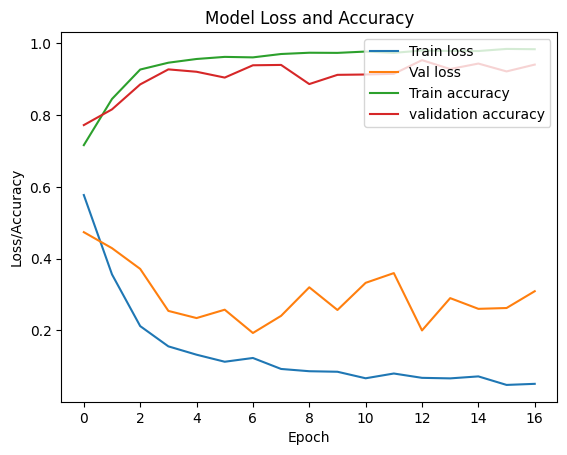

Validation Set:
F1 score for fold 6 0.84688995215311
Accuracy score for fold 6 0.9389895138226882
Test Set:
F1 score for fold 6 0.88
Accuracy score for fold 6 0.9430291801760075


Training on fold 7
Training completed after 24 epochs


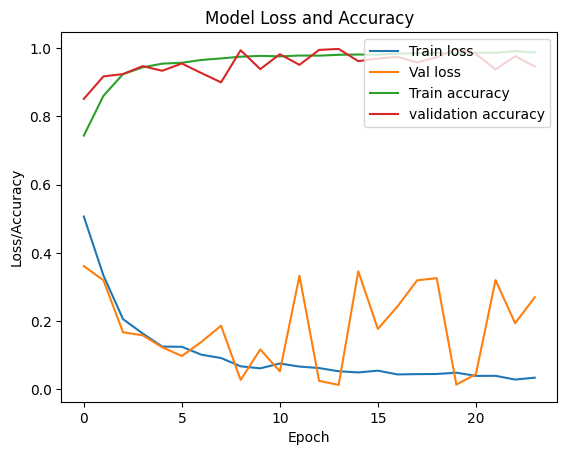

Validation Set:
F1 score for fold 7 0.9953488372093023
Accuracy score for fold 7 0.9980582524271845
Test Set:
F1 score for fold 7 0.927007299270073
Accuracy score for fold 7 0.9629458082445577


Training on fold 8
Training completed after 21 epochs


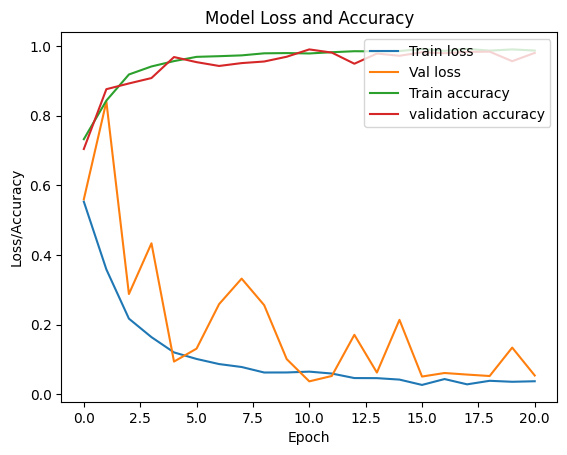

Validation Set:
F1 score for fold 8 0.9837037037037037
Accuracy score for fold 8 0.9899543378995433
Test Set:
F1 score for fold 8 0.9080882352941176
Accuracy score for fold 8 0.953682260305697




In [7]:
k = 8
print(f"Training on {k} folds")

for i in range(k):
    
    train_index = np.where(folds_train != i)[0]
    val_index = np.where(folds_train == i)[0]
    
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    print(f"Training on fold {i+1}")
    
    # create new model
    num_classes = 1
    X_input = keras.Input(shape=X_train.shape[1:])
    outputs, feature_output = cnn.model(X_input, num_classes=num_classes, filters=[12, 18, 24], kernels=[5,5,3], hidden_units=[32, 8], dropout=[0.5, 0.5])
    model = keras.Model(inputs=X_input, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC()])
    
    # evaluate the model (sanity check)
    # y_pred = model.predict(X_val_fold, verbose=0)
    # y_pred_binary = np.round(y_pred)
    # y_true = Y_val_fold
    # print("pre train perf:")
    # print(f"F1 score for fold {i+1}", f1_score(y_true, y_pred_binary), f"\t Accuracy score for fold {i+1}", accuracy_score(y_true, y_pred_binary))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # with data augmentation
    # data_gen = augment_ecg_signal_batch(X_train_fold, Y_train_fold, 32)
    # history = model.fit(data_gen, validation_data=(X_val_fold, Y_val_fold), epochs=50, batch_size=32, steps_per_epoch=len(X_train) // 32, callbacks=[early_stopping], verbose=0)
    
    # train the model
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping])
    print("Training completed after", len(history.epoch), "epochs")
    
    # plot the training and validation loss and binary accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Loss and Accuracy')
    plt.ylabel('Loss/Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Val loss', 'Train accuracy', 'validation accuracy'], loc='upper right')
    plt.show()
    
    # validation performance
    Y_pred_fold = model.predict(X_val_fold, verbose=0)
    Y_pred_binary_fold = np.round(Y_pred_fold)
    Y_true_fold = Y_val_fold
    print("Validation Set:")
    print(f"F1 score for fold {i+1}", f1_score(Y_true_fold, Y_pred_binary_fold))
    print(f"Accuracy score for fold {i+1}", accuracy_score(Y_true_fold, Y_pred_binary_fold))
    
    # test performance
    Y_pred_fold = model.predict(X_test, verbose=0)
    Y_pred_binary_fold = np.round(Y_pred_fold)
    Y_true_fold = Y_test
    print("Test Set:")
    print(f"F1 score for fold {i+1}", f1_score(Y_true_fold, Y_pred_binary_fold))
    print(f"Accuracy score for fold {i+1}", accuracy_score(Y_true_fold, Y_pred_binary_fold))
    print("\n")

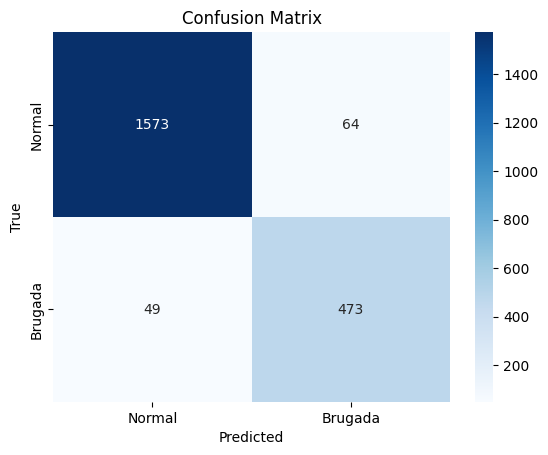

In [41]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred_fold = model.predict(X_test, verbose=0)
Y_pred_binary_fold = np.round(Y_pred_fold)
Y_true_fold = Y_test

cm = confusion_matrix(Y_true_fold, Y_pred_binary_fold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Brugada'], yticklabels=['Normal', 'Brugada'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
num_classes = 1
X_input = keras.Input(shape=X_train.shape[1:])
outputs, feature_output = cnn.model(X_input, num_classes=num_classes, filters=[12, 18, 24], kernels=[5,5,3], hidden_units=[32, 8], dropout=[0.5, 0.5])

model = keras.Model(inputs=X_input, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'Accuracy'])
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 100, 12)]         0         
                                                                 
 conv1d_36 (Conv1D)          (None, 96, 12)            732       
                                                                 
 batch_normalization_36 (Bat  (None, 96, 12)           48        
 chNormalization)                                                
                                                                 
 activation_36 (Activation)  (None, 96, 12)            0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 48, 12)           0         
 g1D)                                                            
                                                                 
 conv1d_37 (Conv1D)          (None, 44, 18)            109

Epoch 1/50
134/134 [==============================] - 3s 7ms/step - loss: 0.6261 - accuracy: 0.6740 - precision: 0.2923 - recall: 0.1357 - Accuracy: 0.6740 - val_loss: 0.5266 - val_accuracy: 0.7961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_Accuracy: 0.7961
Epoch 2/50
134/134 [==============================] - 1s 6ms/step - loss: 0.4897 - accuracy: 0.7484 - precision: 0.6734 - recall: 0.1433 - Accuracy: 0.7484 - val_loss: 0.3894 - val_accuracy: 0.7989 - val_precision: 0.5429 - val_recall: 0.0868 - val_Accuracy: 0.7989
Epoch 3/50
134/134 [==============================] - 1s 5ms/step - loss: 0.3636 - accuracy: 0.8407 - precision: 0.7818 - recall: 0.5561 - Accuracy: 0.8407 - val_loss: 0.3073 - val_accuracy: 0.8771 - val_precision: 0.7843 - val_recall: 0.5479 - val_Accuracy: 0.8771
Epoch 4/50
134/134 [==============================] - 1s 5ms/step - loss: 0.2608 - accuracy: 0.9056 - precision: 0.8476 - recall: 0.8025 - Accuracy: 0.9056 - val_loss: 0.2929 - val_accuracy: 0.8

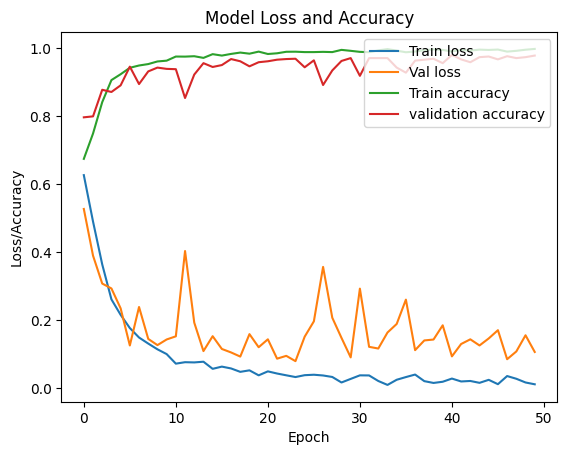

In [36]:
AUGMENT = False

if AUGMENT:
    data_gen = augment_ecg_signal_batch(X_train, Y_train, 32)
    history = model.fit(data_gen, epochs=20, batch_size=32, steps_per_epoch=len(X_train) // 32)
else:
    # split training data into training and validation sets
    X_train, X_val = X_train[:int(0.8 * len(X_train))], X_train[int(0.8 * len(X_train)):]
    Y_train, Y_val = Y_train[:int(0.8 * len(Y_train))], Y_train[int(0.8 * len(Y_train)):]
    data_gen = augment_ecg_signal_batch(X_train, Y_train, 32)
    history = model.fit(data_gen, validation_data=(X_val, Y_val), epochs=50, batch_size=32, steps_per_epoch=len(X_train) // 32)
    # history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=32)

# plot the training and validation loss and binary accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss', 'Train accuracy', 'validation accuracy'], loc='upper right')

In [37]:
from sklearn.metrics import roc_auc_score

# evaluate the model
loss, accuracy, precision, recall, binary_accuracy = model.evaluate(X_test, Y_test)
Y_pred = model.predict(X_test)
roc_auc_score(Y_test, Y_pred)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc_score(Y_test, Y_pred))
print("F1 Score:", 2 * (precision * recall) / (precision + recall))
print("Precision:", precision)
print("Recall:", recall)

# auc score



68/68 [==============================] - 0s 856us/step
Loss: 0.7577897906303406
Accuracy: 0.9601667523384094
ROC AUC Score: 0.9794046674483975
F1 Score: 0.9200743573689625
Precision: 0.8935018181800842
Recall: 0.9482758641242981


In [61]:
# define model that randomly guesses
def random_model(X):
    return np.random.randint(0, 2, X.shape[0])

# evaluate the random model
random_labels = random_model(X_test)
loss, accuracy, precision, recall, binary_accuracy = model.evaluate(X_test, random_labels)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Binary Accuracy:", binary_accuracy)
print("F1 Score:", 2 * (precision * recall) / (precision + recall))


40/40 [==============================] - 1s 9ms/step - loss: 4.7389 - accuracy: 0.4912 - precision: 0.5189 - recall: 0.3765 - binary_accuracy: 0.4912
Loss: 4.738865375518799
Accuracy: 0.4912280738353729
Precision: 0.5189075469970703
Recall: 0.3765243887901306
Binary Accuracy: 0.4912280738353729
F1 Score: 0.436395753072828


In [5]:
# define a resnet model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics

import models.resnet as resnet
    
num_classes = 1
X_input = keras.Input(shape=X_train.shape[1:])
outputs2, feature_output2 = resnet.model(X_input, num_classes=num_classes, filters=[16,16], kernels=[5, 5], layers=4, hidden_units=128)

model2 = keras.Model(inputs=X_input, outputs=outputs2)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 12)]    0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 96, 16)       976         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 96, 16)      64          ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_18 (Activation)     (None, 96, 16)       0           ['batch_normalization_18[0]

In [9]:
# train model (resnet for 1s windowed data)

batch_size = 64

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model2.fit(train_generator, epochs=10, batch_size=batch_size, validation_data=(X_val, y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

NameError: name 'y_train' is not defined

In [13]:
k = 8
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"Training on fold {i+1}")
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]
    
    # Create a new model
    num_classes = 1
    X_input = keras.Input(shape=X_train.shape[1:])
    outputs2, feature_output2 = resnet.model(X_input, num_classes=num_classes, filters=[16,16], kernels=[5, 5], layers=4, hidden_units=128)

    model2 = keras.Model(inputs=X_input, outputs=outputs2)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.binary_accuracy])
        
    # evaluate the model
    y_pred = model2.predict(X_val_fold, verbose=0)
    y_pred_binary = np.round(y_pred)
    y_true = Y_val_fold
    
    print("pre train perf:")
    print(f"F1 score for fold {i+1}", f1_score(y_true, y_pred_binary), f"\t Accuracy score for fold {i+1}", accuracy_score(y_true, y_pred_binary))
    
    
    model2.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=50, batch_size=32, verbose=1)
    
    
    # print(f"evaluating validation set performance of model2 for fold {i+1}")
    Y_pred_fold = model2.predict(X_val_fold, verbose=0)
    Y_pred_binary_fold = np.round(Y_pred_fold)
    Y_true_fold = Y_val_fold
    
    print("Validation Set:")
    print(f"F1 score for fold {i+1}", f1_score(Y_true_fold, Y_pred_binary_fold))
    print(f"Accuracy score for fold {i+1}", accuracy_score(Y_true_fold, Y_pred_binary_fold))
    
    # print(f"Evaluating test set performance of model2 for fold {i+1}")
    Y_pred_fold = model2.predict(X_test, verbose=0)
    Y_pred_binary_fold = np.round(Y_pred_fold)
    Y_true_fold = Y_test
    
    print("Test Set:")
    print(f"F1 score for fold {i+1}", f1_score(Y_true_fold, Y_pred_binary_fold))
    print(f"Accuracy score for fold {i+1}", accuracy_score(Y_true_fold, Y_pred_binary_fold))
    print("\n")

Training on fold 1
pre train perf:
F1 score for fold 1 0.41199684293606953 	 Accuracy score for fold 1 0.2897998093422307
Epoch 1/50
230/230 [==============================] - 6s 11ms/step - loss: 0.3134 - accuracy: 0.8633 - precision: 0.8222 - recall: 0.5819 - binary_accuracy: 0.8633 - val_loss: 0.1584 - val_accuracy: 0.9333 - val_precision: 0.8049 - val_recall: 0.9778 - val_binary_accuracy: 0.9333
Epoch 2/50
230/230 [==============================] - 3s 11ms/step - loss: 0.0982 - accuracy: 0.9661 - precision: 0.9346 - recall: 0.9300 - binary_accuracy: 0.9661 - val_loss: 0.0415 - val_accuracy: 0.9867 - val_precision: 0.9706 - val_recall: 0.9778 - val_binary_accuracy: 0.9867
Epoch 3/50
230/230 [==============================] - 3s 11ms/step - loss: 0.0565 - accuracy: 0.9812 - precision: 0.9606 - recall: 0.9648 - binary_accuracy: 0.9812 - val_loss: 0.1120 - val_accuracy: 0.9590 - val_precision: 0.8626 - val_recall: 1.0000 - val_binary_accuracy: 0.9590
Epoch 4/50
230/230 [===============

In [15]:
# evaluate model
loss, accuracy, precision, recall, binary_accuracy = model2.evaluate(X_test, Y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Binary Accuracy:", binary_accuracy)
print("F1 Score:", 2 * (precision * recall) / (precision + recall))

68/68 [==============================] - 0s 3ms/step - loss: 0.3071 - accuracy: 0.9667 - precision: 0.8975 - recall: 0.9732 - binary_accuracy: 0.9667     
Loss: 0.30708548426628113
Accuracy: 0.966651201248169
Precision: 0.8975265026092529
Recall: 0.9731800556182861
Binary Accuracy: 0.966651201248169
F1 Score: 0.933823520195216


# ResNet Full Model

Epoch 1/20
10/10 [==============================] - 0s 23ms/step - loss: 0.1541 - accuracy: 0.9406 - precision: 0.9583 - recall: 0.8915 - binary_accuracy: 0.9406 - val_loss: 0.5480 - val_accuracy: 0.8723 - val_precision: 0.7600 - val_recall: 1.0000 - val_binary_accuracy: 0.8723
Epoch 2/20
10/10 [==============================] - 0s 20ms/step - loss: 0.1012 - accuracy: 0.9656 - precision: 0.9310 - recall: 0.9730 - binary_accuracy: 0.9656 - val_loss: 0.4747 - val_accuracy: 0.8936 - val_precision: 0.8182 - val_recall: 0.9474 - val_binary_accuracy: 0.8936
Epoch 3/20
10/10 [==============================] - 0s 20ms/step - loss: 0.2029 - accuracy: 0.9187 - precision: 0.9043 - recall: 0.8739 - binary_accuracy: 0.9187 - val_loss: 0.2922 - val_accuracy: 0.9362 - val_precision: 0.9000 - val_recall: 0.9474 - val_binary_accuracy: 0.9362
Epoch 4/20
10/10 [==============================] - 0s 19ms/step - loss: 0.1754 - accuracy: 0.9344 - precision: 0.9636 - recall: 0.8618 - binary_accuracy: 0.9344 -

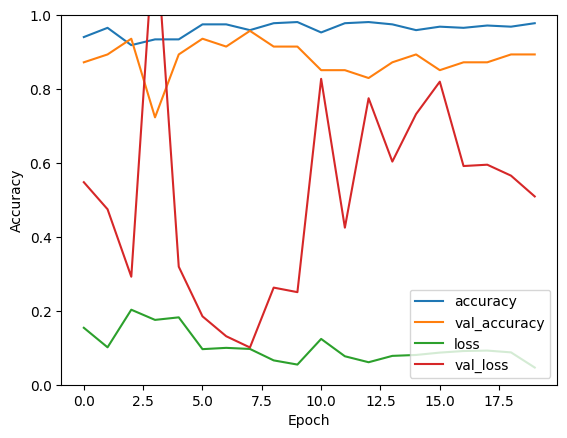

In [49]:
# train model (resnet for full record data)

batch_size = 32

train_generator = augment_ecg_signal_batch(X_train, Y_train, batch_size=batch_size)

history = model2.fit(train_generator, epochs=20, batch_size=batch_size, validation_data=(X_val, Y_val), steps_per_epoch=X_train.shape[0]//batch_size, verbose=1)

# plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [50]:
# evaluate model
loss, accuracy, precision, recall, binary_accuracy = model2.evaluate(X_test, Y_test)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Binary Accuracy:", binary_accuracy)
print("F1 Score:", 2 * (precision * recall) / (precision + recall))


3/3 [==============================] - 0s 4ms/step - loss: 0.5405 - accuracy: 0.8438 - precision: 0.7436 - recall: 0.8529 - binary_accuracy: 0.8438
Loss: 0.5405235290527344
Accuracy: 0.84375
Precision: 0.7435897588729858
Recall: 0.8529411554336548
Binary Accuracy: 0.84375
F1 Score: 0.7945205475425465
